In [1]:
import vtk
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:

## plot two atlases to highlight common structure + count common structures
class scrollable_image():
    def __init__(self, image_path, reader_type, z_slice, colour_window, colour_level):
        self.image_path = image_path
        self.reader_type = reader_type
        self.z_slice = z_slice
        self.colour_window = colour_window
        self.colour_level = colour_level

        # keep updated with obj at current step in pipeline
        # to allow pipeline steps to varry
        self.current_step = None
        self.has_text_actor = False

        self.colour_bar_num_colours = 0

    def read_image(self):
        if self.reader_type == "DICOM":
            dicom_reader = vtk.vtkDICOMImageReader()
            dicom_reader.SetDirectoryName(self.image_path)
            self.reader = dicom_reader
        else:
            nifti_reader = vtk.vtkNIFTIImageReader()
            nifti_reader.SetFileName(self.image_path)
            self.reader = nifti_reader

        self.reader.Update()
        self.current_step = self.reader

        # set num z slices in img
        self.z_slices = self.reader.GetOutput().GetDimensions()[2]
    
    def resize_image(self, render_size):
        self.resizer = vtk.vtkImageResize()
        self.resizer.SetInputConnection(self.current_step.GetOutputPort())
        # gets original dimensions
        original_dims = np.asarray(self.resizer.GetOutput().GetDimensions())
        new_dims = list( original_dims*(render_size/original_dims[0:1].max()).astype(int))

        # adjusts output dimensions of the image
        self.resizer.SetOutputDimensions(*new_dims)
        self.resizer.Update()

        # scale zslice as well - doesn't seem needed rn???
        #self.z_slice = self.z_slice*(render_size/original_dims[0:1].max()).astype(int)

        self.current_step = self.resizer

    def map_image(self):
        self.mapper = vtk.vtkImageMapper()
        self.mapper.SetInputConnection(self.current_step.GetOutputPort())

        self.mapper.SetColorWindow(self.colour_window)
        self.mapper.SetColorLevel(self.colour_level)
        self.mapper.SetZSlice(self.z_slice)
        self.mapper.Update()

        self.current_step = self.mapper

    def add_colour_mapper(self, num_values):
        # TODO: replace there with params?
        opacity_common = 1.0
        opacity_not_common = 0.0

        num_unique_structures = 250
        num_comparable_structures = 20
        
        # create lookup table
        lut = vtk.vtkLookupTable()
        lut.SetNumberOfTableValues(num_values + 1) # add one to account for included background at 0
        lut.SetRange(0, num_values)
        lut.Build()

        self.colour_bar_lut = vtk.vtkLookupTable()
        self.colour_bar_lut.SetNumberOfTableValues(num_comparable_structures)
        self.colour_bar_lut.SetRange(num_unique_structures + 1, num_unique_structures + num_comparable_structures)
        self.colour_bar_lut.Build()

        color_series = vtk.vtkColorSeries()
        # choose the vtk colour scheme
        color_series.SetColorScheme(vtk.vtkColorSeries.BREWER_QUALITATIVE_SET3)

        # include 0 and go to num_unique_structures + 1 to account for a black bnackground when intensity is 0
        grayscale_lut = [i for i in np.linspace(0, 255, num_unique_structures + 1, dtype=int)]
        grey_offset = 0

        # map the colour series into the lut - can't do automatically
        num_colours_in_map = color_series.GetNumberOfColors()
        for i in range(0, num_values + 1):            
            # scale to proper colours - lighter for non compared
            if i <= num_unique_structures: # num of un aligned structures
                lut.SetTableValue(i, grayscale_lut[i], grayscale_lut[i], grayscale_lut[i], opacity_not_common)

            # if structure in both atlases
            else: 
                if self.colour_bar_num_colours >= 8:
                    grey_offset = 1
                if self.colour_bar_num_colours >= 8 + num_colours_in_map - 1:
                    grey_offset = 2
                    
                colour = color_series.GetColor((self.colour_bar_num_colours + grey_offset)  % num_colours_in_map)

                # for first loop over colours
                if self.colour_bar_num_colours < (num_colours_in_map - 1):
                    scale = 255
                elif self.colour_bar_num_colours < 2*(num_colours_in_map - 1):
                    scale = 150
                else:
                    scale = 5
            
                
                # save comparable structures
                #if i != num_unique_structures + 14 and i != num_unique_structures + 15: # add hoc fix - ignore optic tract since optic tract != optic chasim (don't plot as comparable)
                lut.SetTableValue(i, colour.GetRed() / scale, colour.GetGreen() / scale, colour.GetBlue() / scale, opacity_common)
                
                self.colour_bar_lut.SetTableValue(self.colour_bar_num_colours, colour.GetRed() / scale, colour.GetGreen() / scale, colour.GetBlue() / scale, 1.0)
                
                self.colour_bar_num_colours += 1
                #else:
                    #lut.SetTableValue(i, colour.GetRed() / scale, colour.GetGreen() / scale, colour.GetBlue() / scale, 0.0) # don't highlight optic tract or chasim
                

        self.colour_mapper = vtk.vtkImageMapToColors()
        self.colour_mapper.SetInputConnection(self.current_step.GetOutputPort())
        self.colour_mapper.SetLookupTable(lut)
        self.colour_mapper.PassAlphaToOutputOn()
        self.colour_mapper.Update()

        self.current_step = self.colour_mapper


    def add_actor(self):
        self.actor = vtk.vtkActor2D()
        self.actor.SetMapper(self.current_step)

    def add_text_actor(self):
        self.has_text_actor = True
        self.text_actor = vtk.vtkTextActor()
        self.text_actor.GetTextProperty().SetFontSize(24)
        self.text_actor.GetTextProperty().SetColor(1, 1, 1)
        self.text_actor.SetInput("Slice: " + str(self.z_slice) + "/" + str(self.z_slices))
    
    def set_text_position(self, pos_x, pos_y):
        self.text_actor.SetPosition(pos_x, pos_y)

    def add_colour_bar(self, custom_labels):
        self.colour_bar = vtk.vtkScalarBarActor()
        self.colour_bar.SetLookupTable(self.colour_bar_lut)
        self.colour_bar.SetTitle("Comparable Structures")
        print(self.colour_bar_num_colours)
        self.colour_bar.SetNumberOfLabels(self.colour_bar_num_colours)
        self.colour_bar.SetVerticalTitleSeparation(10)
        self.colour_bar.SetPosition(0, 0)
        self.colour_bar.GetLabelTextProperty().SetOpacity(0)
        self.colour_bar.GetLabelTextProperty().SetFontSize(30)

        # add each label as a text actor (seem like the only way :()
        x_pos = 105
        y_pos = 10
        self.colour_bar_actors = []
        for i in range(self.colour_bar_num_colours): # NOTE: checkoing  if obo error
            text = vtk.vtkTextActor()
            text.SetInput(custom_labels[i])
            text.SetDisplayPosition(x_pos, y_pos + i*26)

            text.GetTextProperty().SetFontSize(23)
        
            self.colour_bar_actors.append(text)

        return self.colour_bar_actors
    
    def create_mousewheel_callbacks(self):
    
        def scroll_forward(obj=None,event=None):
            self.z_slice = min(self.mapper.GetWholeZMax(), self.z_slice + 1)
            self.mapper.SetZSlice(self.z_slice)
            if self.has_text_actor:
                self.text_actor.SetInput("Slice: " + str(self.z_slice) + "/" + str(self.z_slices))

        def scroll_backward(obj=None,event=None):
            self.z_slice = max(self.mapper.GetWholeZMin(),self.mapper.GetZSlice() - 1)
            self.mapper.SetZSlice(self.z_slice)
            if self.has_text_actor:
                self.text_actor.SetInput("Slice: " + str(self.z_slice) + "/" + str(self.z_slices))
            
        return scroll_forward, scroll_backward

    def create_key_press_scroll(self):

        def key_press_scroll(obj, event):
            # Get the type of keypress
            key = obj.GetKeySym()
            
            if key == "Up":
                self.z_slice = min(self.mapper.GetWholeZMax(), self.z_slice + 1)
                self.mapper.SetZSlice(self.z_slice)
                if self.has_text_actor:
                    self.text_actor.SetInput("Slice: " + str(self.z_slice) + "/" + str(self.z_slices))

            elif key == "Down":
                self.z_slice = max(self.mapper.GetWholeZMin(),self.mapper.GetZSlice() - 1)
                self.mapper.SetZSlice(self.z_slice)
                if self.has_text_actor:
                    self.text_actor.SetInput("Slice: " + str(self.z_slice) + "/" + str(self.z_slices))
            self.window.Render()
        return key_press_scroll
    
    def set_render_window(self, window):
        self.window = window

    def get_image_data(self):
        return self.reader.GetOutput()
    


In [9]:
# NOTE: the resampling of these labels should match the resampling of the 
# images to use for training!

human_labels_image_path =  "./sub-1000336_n4.nii" #"./atlases/human_seg_common_proc.nii" # "./data/human/processed_labels/sub-1000336_n4.nii"
mouse_labels_image_path =  "./01sub.nii" # "./data/mouse/processed_labels/01sub.nii"

human_atlas_image_path = "./atlases/human_atlas_common_proc.nii"
mouse_atlas_image_path = "./atlases/mouse_atlas_common_proc.nii"

reader_type = "NIFTY"
z_slice = 300
render_size_x = 500
render_size_y = 700
offset_for_colour_bar = 200
label_opacity = 0.5
render_atlas_MRIs = True

render_size = max(render_size_x, render_size_y)

# taken from itk snap default
mouse_MRI_colour_window = 31458552
mouse_MRI_colour_level = 15729276

human_MRI_colour_window = 96.21
human_MRI_colour_level = 48.11

# process and print the areas of common features at z_slice
get_areas = True

###################################################################### params done

human_labels_sitk = sitk.ReadImage(human_labels_image_path)
human_labels_np = sitk.GetArrayFromImage(human_labels_sitk)
human_labels_num_values = human_labels_np.max()

mouse_labels_sitk = sitk.ReadImage(mouse_labels_image_path)
mouse_labels_np = sitk.GetArrayFromImage(mouse_labels_sitk)
mouse_labels_num_values = mouse_labels_np.max()

num_values = max(human_labels_num_values, mouse_labels_num_values).astype(int)

min_intensity = 0
max_intensity = num_values
labels_colour_window = max_intensity - min_intensity
labels_colour_level = (min_intensity + max_intensity) / 2


mouse_labels = scrollable_image(mouse_labels_image_path, reader_type, z_slice, labels_colour_window, labels_colour_level)
mouse_labels.read_image()
mouse_labels.resize_image(render_size)
mouse_labels.add_colour_mapper(num_values)
mouse_labels.map_image()
mouse_labels.add_actor()
mouse_labels.add_text_actor()

human_labels = scrollable_image(human_labels_image_path, reader_type, z_slice, labels_colour_window, labels_colour_level)
human_labels.read_image()
human_labels.resize_image(render_size)
human_labels.add_colour_mapper(num_values)
human_labels.map_image()
human_labels.add_actor()
human_labels.add_text_actor()

if render_atlas_MRIs:
    mouse_atlas_sitk = sitk.GetArrayFromImage(sitk.ReadImage(mouse_atlas_image_path))
    print("min", np.min(mouse_atlas_sitk))
    print("max", np.max(mouse_atlas_sitk))

    human_atlas_sitk = sitk.GetArrayFromImage(sitk.ReadImage(human_atlas_image_path))
    print("min", np.min(human_atlas_sitk))
    print("max", np.max(human_atlas_sitk))

    # render mouse MRI image (no colour mapper to just render greyscale image)
    mouse_atlas = scrollable_image(mouse_atlas_image_path, reader_type, z_slice, mouse_MRI_colour_window, mouse_MRI_colour_level)
    mouse_atlas.read_image()
    mouse_atlas.resize_image(render_size)
    mouse_atlas.map_image()
    mouse_atlas.add_actor()

    # render human MRI image (no colour mapper to just render greyscale image)
    human_atlas = scrollable_image(human_atlas_image_path, reader_type, z_slice, human_MRI_colour_window, human_MRI_colour_level)
    human_atlas.read_image()
    human_atlas.resize_image(render_size)
    human_atlas.map_image()
    human_atlas.add_actor()


# add a colour bar with the human_labels rendering
custom_labels = ['lateral ventricle', 'amygdala', 'fourth ventricle', 'thalamus', 'third ventricle', 'hippocampus', 'basal forebrain', 'cerebellum WM', 'nucleus accumbens', 'globus pallidus']

custom_labels_LR = [side_label for label in custom_labels for side_label in [label + " R", label + " L"]]
colour_bar_text_actors = human_labels.add_colour_bar(custom_labels_LR) # NOTE: currently doesn't custom labels just segmentation value

actors = {
    "mouse_labels": mouse_labels.actor,
    "human_labels": human_labels.actor,
    "mouse_text": mouse_labels.text_actor,
    "human_text": human_labels.text_actor,
    "colour_bar": human_labels.colour_bar,
}

mappers = {
    "mouse_labels": mouse_labels.mapper,
    "human_labels": human_labels.mapper,
}

if render_atlas_MRIs:
    actors["mouse_atlas"] = mouse_atlas.actor
    mappers["mouse_atlas"] = mouse_atlas.mapper

    actors["human_atlas"] = human_atlas.actor
    mappers["human_atlas"] = human_atlas.mapper


# define interactor and rendering
interactor = vtk.vtkRenderWindowInteractor()
renderer = vtk.vtkRenderer()
renderer.SetBackground(0, 0, 0) # make sure background is black

window = vtk.vtkRenderWindow()
actors["human_labels"].GetPositionCoordinate().SetValue(render_size_x + offset_for_colour_bar, 0) # add offset
actors["mouse_labels"].GetPositionCoordinate().SetValue(offset_for_colour_bar, 0) # add offset

if render_atlas_MRIs:
    actors["human_atlas"].GetPositionCoordinate().SetValue(render_size_x + offset_for_colour_bar, 0) # add offset
    actors["mouse_atlas"].GetPositionCoordinate().SetValue(offset_for_colour_bar, 0) # add offset

window.SetSize(2*render_size_x + 200, render_size_y)

# position the text TODO: make centered!!
mouse_labels.set_text_position(195 + offset_for_colour_bar, render_size_y - 150)
human_labels.set_text_position(690 + offset_for_colour_bar, render_size_y - 150)

window.AddRenderer(renderer)
interactor.SetRenderWindow(window)


fwd, bwd = mouse_labels.create_mousewheel_callbacks()
interactor.AddObserver('MouseWheelForwardEvent', fwd)
interactor.AddObserver('MouseWheelBackwardEvent', bwd)

kp = human_labels.create_key_press_scroll()
interactor.AddObserver("KeyPressEvent", kp)
# set render window to update on keypress
human_labels.set_render_window(window)

if render_atlas_MRIs:
    fwd, bwd = mouse_atlas.create_mousewheel_callbacks()
    interactor.AddObserver('MouseWheelForwardEvent', fwd)
    interactor.AddObserver('MouseWheelBackwardEvent', bwd)

    kp = human_atlas.create_key_press_scroll()
    interactor.AddObserver("KeyPressEvent", kp)
    # set render window to update on keypress
    human_atlas.set_render_window(window)

# Add actors to the renderer
# reverse the list so it overlays the labels if rendering atlas MRI too
for key in reversed(list(actors)):
    renderer.AddActor(actors[key])

# add colour bar labels to render
for text_actor in colour_bar_text_actors:
    renderer.AddActor(text_actor)

# Display
window.Render()
interactor.SetInteractorStyle(vtk.vtkInteractorStyleTrackballCamera())  # Ensure proper interaction style
interactor.Initialize()
interactor.Start()


c:\Users\jessi\miniconda3\envs\mdsc689-03\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in long_scalars


min 0.0
max 31458552.0
min 0.0
max 96.21364
20


In [4]:
# Create a dict of labels and their value - in vtk
# if get_areas:
#     mouse_labels_data = mouse_labels.get_image_data()
#     mouse_labels_scalar = mouse_labels_data.GetPointData().GetScalars()
#     mouse_labels_np = vtk.util.numpy_support.vtk_to_numpy(mouse_labels_scalar) # TODO: switch with other conversion

#     human_labels_data = human_labels.get_image_data()
#     human_labels_scalar = human_labels_data.GetPointData().GetScalars()
#     human_labels_np = vtk.util.numpy_support.vtk_to_numpy(human_labels_scalar)

#     # same spacing for both since registered to common place
#     full_mouse_brain_num_voxels = np.sum(mouse_labels_np != 0)
#     full_human_brain_num_voxels = np.sum(human_labels_np != 0)
#     for common_struct in common_structs:
#         print(common_struct)
        
#         mouse_struct_num_voxels = np.sum(mouse_labels_np == common_structs[common_struct])
#         human_struct_num_voxels = np.sum(human_labels_np == common_structs[common_struct])

#         mouse_struct_rel_area = mouse_struct_num_voxels / full_mouse_brain_num_voxels
#         human_struct_rel_area = human_struct_num_voxels / full_human_brain_num_voxels



In [5]:
custom_labels = ['lateral ventricle', 'amygdala', '4th ventricle', 'thalamus', '3rd ventricle', 'hippocampus', 'basal forebrain', 'cerebellum WM', 'nucleus accumbens', 'globus pallidus']
custom_labels_LR = [side_label for label in custom_labels for side_label in [label + " R", label + " L"]]
common_stuct_start_idx = 251
common_structs = {}

for i, label in enumerate(custom_labels_LR):
    common_structs[label] = common_stuct_start_idx + i
    
def calc_rel_area(image_np, common_struct, L_or_R, common_structs, total_vox=0):
    if total_vox == 0:
        total_vox = np.sum(image_np != 0)

    struct_vox = 0
    if L_or_R == "L" or L_or_R == "both":   
        struct_vox += np.sum(image_np == common_structs[common_struct + " L"])

    if L_or_R == "R" or L_or_R == "both":   
        struct_vox += np.sum(image_np == common_structs[common_struct + " R"])
    
    rel_area = struct_vox / total_vox

    return rel_area

# set colour to match labels rendering
color_series = vtk.vtkColorSeries()
# choose the vtk colour scheme
color_series.SetColorScheme(vtk.vtkColorSeries.BREWER_QUALITATIVE_SET3)

# skip over grey (idx = 8) in colour series
grey_offset = 0
num_colours_in_map = color_series.GetNumberOfColors()

num_colours = len(common_structs)
print(num_colours)
np_colours = np.zeros((num_colours, 3))
for i in range(num_colours):
    if i >= 8:
        grey_offset = 1
    if i >= 8 + num_colours_in_map - 1:
        grey_offset = 2

    colour = color_series.GetColor((i + grey_offset)  % num_colours_in_map)
    np_colours[i] = np.array([colour.GetRed(), colour.GetGreen(), colour.GetBlue()]) / 255.0


    


20


In [ ]:
import os

# For a certain z_slice - iterate over all registered labels and compute the area of that structure
human_labels_image_path = "./atlases/human_seg_common_proc.nii" 
mouse_labels_image_path = "./atlases/mouse_seg_common_proc.nii"
human_folder_path = "./data/human/processed_labels/"
mouse_folder_path = "./data/mouse/processed_labels/"


folder_path = human_folder_path
image_path = human_labels_image_path

reader_type = "NIFTY"
L_or_R = "both"
z_slice = 276

areas = []
for i, file_name in enumerate(os.listdir(folder_path)):
    image_path = folder_path + file_name#"./atlases/mouse_labels_common_proc.nii"
    areas.append([])

    image = sitk.ReadImage(image_path)
    image_np = sitk.GetArrayFromImage(image)[z_slice + 29, :, :]

    #print(image_np.shape)
    #plt.imshow(image_np, cmap="gray", alpha=1.0) 
    total_vox = np.sum(image_np != 0)

    # loop over each structure
    for struct in custom_labels:
        area = calc_rel_area(image_np, struct, L_or_R, common_structs, total_vox)
        areas[i].append(area)

# plot histograms over the size
areas_np = np.array(areas)
np.save("./metrics_data/human_struct_areas_z_slice_" + str(z_slice), areas_np)


272.0


(49, 11)


Text(0.5, 1.0, 'Mouse MRI - common structure areas (slice 267)')

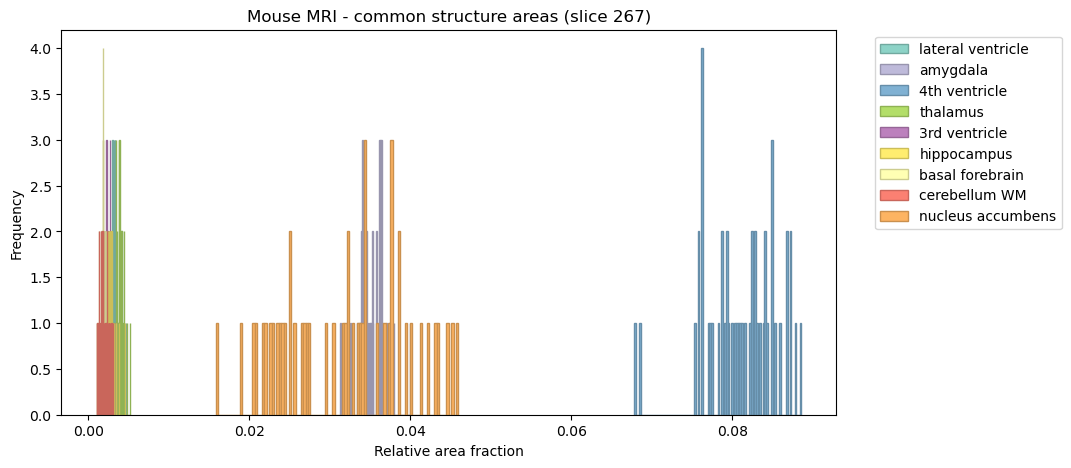

In [7]:
z_slice = 267
areas_np = np.load("./metrics_data/mouse_struct_areas_z_slice_" + str(z_slice) + ".npy")
#areas_np = np.load("./metrics_data/mouse_struct_areas_z_slice_" + str(z_slice) + ".npy")
print(areas_np.shape)

plt.figure(figsize=(10,5))
offset = 0
labels = []
col_num = 1
# plot histograms over the size
for i, struct in enumerate(custom_labels):
    if struct != "optic tract":
        data = areas_np[:, i]

        # only plot if that structure is in the slice
        if np.sum(data) != 0:
            plt.hist(data, bins=100, edgecolor=np_colours[2*(i - offset)]*0.8, color=np_colours[2*(i - offset)])
            plt.xlabel("Relative area fraction")
            plt.ylabel("Frequency")
            labels.append(struct)
    else: 
        offset = 1

plt.legend(labels, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Mouse MRI - common structure areas (slice " + str(z_slice) + ")")


### TODO:
- add labels to colour bar

In [8]:
import SimpleITK as sitk
from nilearn.datasets import load_mni152_gm_mask

# Load the MNI152 GM mask using nilearn
gm_mask = load_mni152_gm_mask()

# Convert the nilearn NIfTI image to SimpleITK Image
gm_mask_sitk = sitk.GetImageFromArray(gm_mask.get_fdata())

# Step 2: Load the atlas (replace with your atlas file path)
# For demonstration, I will assume you have an atlas image (this could be any reference image)
atlas_image = sitk.ReadImage("./atlases/human_atlas_bet.nii")

# Step 3: Perform an orientation alignment between the GM mask and the atlas
# Here we are using `Resample` to match the orientation of the atlas

# Define the resampler
resampler = sitk.ResampleImageFilter()
resampler.SetSize(atlas_image.GetSize())  # Match the size of the atlas
resampler.SetOutputSpacing(atlas_image.GetSpacing())  # Match the spacing of the atlas
resampler.SetOutputOrigin(atlas_image.GetOrigin())  # Match the origin of the atlas
resampler.SetOutputDirection(atlas_image.GetDirection())  # Match the direction of the atlas

# Apply the resampling to reorient the GM mask to the atlas orientation
reoriented_gm_mask = resampler.Execute(gm_mask_sitk)

"""
import SimpleITK as sitk

from nilearn.datasets import load_mni152_gm_mask
gm_mask = load_mni152_gm_mask()



# Load your MNI152 atlas image (reference image)
mni_atlas = sitk.ReadImage("./atlases/human_atlas_bet.nii")

# Load the grey matter mask (source image)
gm_mask = sitk.ReadImage("./temp_analysis/gw_matter_mask.nii")

gm_mask.SetOrigin(mni_atlas.GetOrigin())
gm_mask.SetSpacing(mni_atlas.GetSpacing())
gm_mask.SetDirection(mni_atlas.GetDirection())
sitk.WriteImage(gm_mask, "./temp_analysis/gw_matter_mask_reorient.nii")


# Resample the grey matter mask to match the atlas dimensions
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(mni_atlas)  # Set atlas as reference for resampling
resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Nearest neighbor for binary masks
resampler.SetDefaultPixelValue(0)  # Background value

# Apply resampling
resampled_gm_mask = resampler.Execute(gm_mask)

# Save the resampled grey matter mask
sitk.WriteImage(resampled_gm_mask, "./temp_analysis/gw_matter_mask_resampled.nii")

print("Resampling complete! The grey matter mask now matches the MNI atlas dimensions.")"""


c:\Users\jessi\miniconda3\envs\mdsc689-03\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


'\nimport SimpleITK as sitk\n\nfrom nilearn.datasets import load_mni152_gm_mask\ngm_mask = load_mni152_gm_mask()\n\n\n\n# Load your MNI152 atlas image (reference image)\nmni_atlas = sitk.ReadImage("./atlases/human_atlas_bet.nii")\n\n# Load the grey matter mask (source image)\ngm_mask = sitk.ReadImage("./temp_analysis/gw_matter_mask.nii")\n\ngm_mask.SetOrigin(mni_atlas.GetOrigin())\ngm_mask.SetSpacing(mni_atlas.GetSpacing())\ngm_mask.SetDirection(mni_atlas.GetDirection())\nsitk.WriteImage(gm_mask, "./temp_analysis/gw_matter_mask_reorient.nii")\n\n\n# Resample the grey matter mask to match the atlas dimensions\nresampler = sitk.ResampleImageFilter()\nresampler.SetReferenceImage(mni_atlas)  # Set atlas as reference for resampling\nresampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Nearest neighbor for binary masks\nresampler.SetDefaultPixelValue(0)  # Background value\n\n# Apply resampling\nresampled_gm_mask = resampler.Execute(gm_mask)\n\n# Save the resampled grey matter mask\nsitk.W